# Essay Grading System

## Motivation

Automated essay grading systems can significantly streamline the assessment process in educational settings, providing consistent and objective evaluations. This implementation aims to demonstrate how large language models and graph-based workflows can be combined to create a sophisticated grading system.

## Key Components

1. State Graph: Defines the workflow of the grading process.

2. LLM Model: Provides the underlying language understanding and analysis.
3. Grading Functions: Functions for evaluation criterias.
4. Conditional Logic: Determines the flow of the grading process based on interim scores.

## Method

The system follows a step-by-step approach to grade essays:

1. Content Relevance: Assesses how well the essay addresses the given topic.

2. Grammar Check: Evaluates the essay's language usage and grammatical correctness.
3. Structure Analysis: Examines the organization and flow of ideas in the essay.
4. Depth of Analysis: Gauges the level of critical thinking and insights presented.

## Required Packages

- Langchain
- langgraph
- langchain-groq
- python-dotenv

## Setup and Imports

In [1]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_core.prompts import ChatPromptTemplate
from IPython.display import display, Image
from pydantic import BaseModel
from langchain_groq import ChatGroq
from dotenv import load_dotenv
load_dotenv()

True

## Language Model Initialization

In [2]:
llm = ChatGroq(model="qwen-qwq-32b", temperature=0)

## State Definition

The state class represents the state of the grading graph.

In [3]:
class State(TypedDict):
    topic: str
    essay: str
    relevance_score: float
    grammar_score: float
    structure_score: float
    depth_score: float
    final_score: float

## Classes to Extract Structured LLM Output

In [4]:
class Relevance(BaseModel):
    relevance_score: float

class Grammar(BaseModel):
    grammar_score: float

class Structure(BaseModel):
    structure_score: float

class Depth(BaseModel):
    depth_score: float

## Grading Functions

The functions used in the grading process.

In [5]:
def check_relevance(state: State):
    """Checks relevance of the essay."""
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", "Analyze the following essay and give a relevance score between 0 and 1 for the given topic."),
            ("user", "Topic: {topic}.\nEssay content: {content}"),
        ]
    )
    
    chain = prompt | llm.with_structured_output(Relevance)
    response = chain.invoke({
        "topic": state["topic"],
        "content": state["essay"],
    })
    
    return {"relevance_score": response.relevance_score}

def check_grammar(state: State):
    """Checks grammar of the essay."""
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", "Analyze the following essay and give a grammar score bwtween 0 and 1."),
            ("user", "Essay: {content}"),
        ]
    )
    
    chain = prompt | llm.with_structured_output(Grammar)
    response = chain.invoke({
        "content": state["essay"],
    })
    
    return {"grammar_score": response.grammar_score}

def check_structure(state: State):
    """Checks structure of the essay."""
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", "Analyze the structure of the following essay and give a structure score between 0 and 1."),
            ("user", "Essay: {content}"),
        ]
    )
    
    chain = prompt | llm.with_structured_output(Structure)
    response = chain.invoke({"content": state["essay"]})
    
    return {"structure_score": response.structure_score}

def check_depth(state: State):
    """Check the depth of the essay."""
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", "Analyze the depth of the given essay for the given topic and give a depth_score between 0 and 1"),
            ("user", "Topic: {topic}.\nEssay content: {content}"),
        ]
    )
    chain = prompt | llm.with_structured_output(Depth)
    response = chain.invoke({
        "topic": state["topic"],
        "content": state["essay"],
    })
    
    return {"depth_score": response.depth_score}

def calculate_final_score(state: State):
    """Calculates the final score by using a weighted sum of all the individual scores."""
    final_score = (
        state["relevance_score"] * 0.3 +
        state["grammar_score"] * 0.2 +
        state["structure_score"] * 0.2 +
        state["depth_score"] * 0.3
    )
    
    return {"final_score": final_score}

## Define the Graph

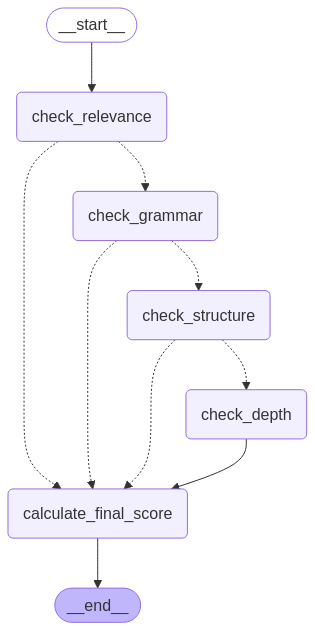

In [6]:
builder = StateGraph(State)

# Add Nodes
builder.add_node("check_relevance", check_relevance)
builder.add_node("check_grammar", check_grammar)
builder.add_node("check_structure", check_structure)
builder.add_node("check_depth", check_depth)

builder.add_node("calculate_final_score", calculate_final_score)

# Add Edges
builder.add_edge(START, "check_relevance")
builder.add_conditional_edges("check_relevance",
                              lambda x: "calculate_final_score" if x["relevance_score"] < 0.5 else "check_grammar",
                              ["calculate_final_score", "check_grammar"])
builder.add_conditional_edges("check_grammar",
                              lambda x: "calculate_final_score" if x["grammar_score"] < 0.6 else "check_structure",
                              ["calculate_final_score", "check_structure"])
builder.add_conditional_edges("check_structure",
                              lambda x: "calculate_final_score" if x["structure_score"] < 0.6 else "check_depth",
                              ["calculate_final_score", "check_depth"])
builder.add_edge("check_depth","calculate_final_score")

builder.add_edge("calculate_final_score", END)

# Compile
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))
# print(graph.get_graph().draw_ascii())

## Driver Function

The driver function is responsible for executing the workflow and returning the resultant score.

In [ ]:
def driver(topic: str, essay: str):
    """Invokes the graph and returns the result.
    Args:
        topic(str): The topic of the essay.
        essay(str): The essay to grade.
    """
    
    initial_state = State(
        topic=topic,
        essay=essay,
        relevance_score=0.0,
        grammar_score=0.0,
        structure_score=0.0,
        depth_score=0.0,
        final_score=0.0
    )
    
    result = graph.invoke(initial_state)
    return result

## Testing the Graph

In [28]:
sample_topic = "Natural Selection"

sample_essay = """
Natural selection, the engine of evolution, does not necessarily favor the strongest or the most intelligent species but rather those that are best suited to adapt to changing environments.
For example, dinosaurs were among the most powerful creatures to have ever existed, yet they could not withstand the extreme climate shifts caused by an asteroid impact.
In contrast, smaller and more adaptable species, like mammals, managed to survive and flourish, ultimately paving the way for the emergence of humans. 

Microscopic organisms like bacteria continually adapt to new antibiotics, evolving into drug-resistant strains.
Their rapid adaptability is what ensures their continued existence despite medical advancements aimed at eradicating them.
This underscores that survival is not about power or intelligence alone, but about adjusting quickly to new circumstances. 

The Mughal Empire (16th–19th Century CE), the most powerful empire in India, failed to adapt to changing economic and political realities.
Their inability to decentralize power, reform taxation, and counter emerging threats like the British East India Company led to their downfall.
Many Rajput kingdoms, despite their bravery, resisted change and modernization.
Their rigid adherence to traditional warfare and reluctance to adopt new military technologies (such as firearms) made them vulnerable to the Mughals and later the British. 

Societies that embraced technological advancements during the Industrial Revolution prospered, while those that resisted change lagged behind.
The Industrial Revolution (18th–19th century) transformed global economies, and nations that embraced technological advancements prospered,
while those that resisted fell behind. Great Britain (18th–19th Century) as the birthplace of the Industrial Revolution,
Britain rapidly mechanized its textile, coal, and iron industries. Innovations like the steam engine, power loom,
and mechanized spinning helped it dominate global trade and establish itself as an economic superpower."""

In [45]:
result = driver(topic=sample_topic, essay=sample_essay)

print(f'Relevance Score: {result["relevance_score"]:.2f}')
print(f'Grammar Score: {result["grammar_score"]:.2f}')
print(f'Structure Score: {result["structure_score"]:.2f}')
print(f'Depth Score: {result["depth_score"]:.2f}')
print(f'Final Score: {result["final_score"]:.2f}')

Relevance Score: 0.85
Grammar Score: 0.95
Structure Score: 0.80
Depth Score: 0.80
Final Score: 0.84
